In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import datetime
import tqdm
import time

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

plt.rc("figure", figsize=(30, 15))

# Define BreathWaveform

In [3]:
import os
import numpy as np

DEFAULT_PRESSURE_RANGE = (5.0, 35.0)
DEFAULT_KEYPOINTS = [0.5, 1.0, 1.5, 3.0]


class BreathWaveform:
    """Waveform generator with shape /‾\_"""

    def __init__(self, range=None, keypoints=None):
        self.lo, self.hi = range or DEFAULT_PRESSURE_RANGE
        self.xp = [0] + (keypoints or DEFAULT_KEYPOINTS)
        self.fp = [self.lo, self.hi, self.hi, self.lo, self.lo]

    @property
    def period(self):
        return self.xp[-1]

    def at(self, t):
        return np.interp(t, self.xp, self.fp, period=self.period)

    def phase(self, t):
        return np.searchsorted(self.xp, t % self.period, side="right")

# Define Controller

In [4]:
import os
import abc
from enum import Enum
import numpy as np
import pickle


ControllerRegistry = []


class Phase(Enum):
    RAMP_UP = 1
    PIP = 2
    RAMP_DOWN = 3
    PEEP = 4


class Controller(abc.ABC):
    def __new__(cls, *args, **kwargs):
        obj = object.__new__(cls)
        obj.__setattr__("name", cls.__name__)
        obj.__setattr__("time", float("inf"))
        obj.__setattr__("waveform", BreathWaveform())
        obj.__setattr__("timeseries", ["t", "state", "target", "u_in", "u_out"])
        obj.__setattr__("log_initialized", False)

        for kw, arg in kwargs.items():
            obj.__setattr__(kw, arg)

        return obj

    @classmethod
    def __init_subclass__(cls, *args, **kwargs):
        super().__init_subclass__(*args, **kwargs)
        if cls.__name__ not in [ctrl.__name__ for ctrl in ControllerRegistry]:
            ControllerRegistry.append(cls)

    @abc.abstractmethod
    def compute_action(self, state, t):
        pass

    def feed(self, state, t):
        u_in, u_out = self.compute_action(state, t)
        self.time = t
        if hasattr(self, "log_directory"):
            self.update_log(t, state, self.waveform.at(t), u_in, u_out)
        return u_in, u_out

    def u_out(self, t):
        phase = self.phase(t)
        u_out = np.zeros_like(phase)
        u_out[np.equal(phase, Phase.RAMP_DOWN.value)] = 1
        u_out[np.equal(phase, Phase.PEEP.value)] = 1

        return u_out

    def dt(self, t):
        dt = max(0, t - self.time)
        return dt

    def cycle_phase(self, t):
        return t % self.waveform.period

    def phase(self, t):
        return self.waveform.phase(t)

    def set_log_directory(self, directory):
        setattr(self, "log_directory", directory)

    def update_log(self, t, state, target, u_in, u_out):
        if not self.log_initialized:
            self.__setattr__(
                "log_file", open(os.path.join(self.log_directory, "controller_timeseries.csv"), "w")
            )

            cols = ",".join(self.timeseries)
            self.log_file.write(f"{cols}\n")
            self.log_initialized = True

        self.log_file.write(f"{t},{float(state)},{target},{float(u_in)},{u_out}\n")

    def save(self, path, thing=None):
        dirname = os.path.abspath(os.path.dirname(path))
        if not os.path.exists(dirname):
            os.makedirs(dirname)

        with open(path, "wb") as file:
            pickle.dump(thing or self, file)

    @classmethod
    def load(cls, path):
        return pickle.load(open(path, "rb"))

# Define PID

In [5]:
class PID(Controller):
    def __init__(self, K=[3, 4, 0], RC=0.5, **kwargs):
        # controller coeffs
        self.K_P, self.K_I, self.K_D = K

        # controller states
        self.P, self.I, self.D = 0, 0, 0

        self.RC = RC

    def compute_action(self, state, t):
        err = self.waveform.at(t) - state

        dt = self.dt(t)

        self.decay = dt / (dt + self.RC)

        self.I += self.decay * (err - self.I)
        self.D += self.decay * (err - self.P - self.D)
        self.P = err

        u_in = self.K_P * self.P + self.K_I * self.I + self.K_D * self.D

        return (u_in, self.u_out(t))

# Initializing

In [6]:
from vent import io

pid = PID(K=[0.1, 2.0, 0.0])
hal = io.Hal("../vent/io/config/devices.ini")

2020-09-03 17:48:27,123 - vent.common.prefs - INFO - Loaded prefs from /home/pi/vent/prefs.json
2020-09-03 17:48:27,135 - vent.common.prefs - INFO - Saved prefs to /home/pi/vent/prefs.json


  [         adc         ]  opts: {'i2c_bus': 1, 'address': 72}
  [     inlet_valve     ]  opts: {'form': 'Normally Closed'}
  [    control_valve    ]  opts: {'response': '/home/pi/src/vent/vent/io/config/calibration/SMC_PVQ31_5G_23_01N_response', 'form': 'Normally Closed', 'pin': 12}
  [  expiratory_valve   ]  opts: {'pin': 27, 'form': 'Normally Closed'}
  [   pressure_sensor   ]  opts: {'adc': <vent.io.devices.base.ADS1015 object at 0xab317eb0>, 'MUX': 1, 'conversion_factor': 70.3, 'output_span': 2.0, 'offset_voltage': 2.25}
  [    oxygen_sensor    ]  opts: {'adc': <vent.io.devices.base.ADS1015 object at 0xab317eb0>, 'MUX': 3, 'conversion_factor': 70.3, 'output_span': 2.0, 'offset_voltage': 2.2}
  [   flow_sensor_ex    ]  opts: {'adc': <vent.io.devices.base.ADS1015 object at 0xab317eb0>, 'MUX': 0, 'conversion_factor': 1, 'output_span': 4.0, 'offset_voltage': 2.25}


In [17]:
pressures = []
timestamps = []
u_ins = []
u_outs = []
flow_exs = []

begin = datetime.datetime.now().timestamp()

history = np.zeros(3)

for i in tqdm.tqdm(range(300)):
    history = np.roll(history, shift=1)
    history[0] = hal.pressure
    pressure = np.mean(history)
    timestamp = datetime.datetime.now().timestamp() - begin
    if pressure > 50:
        print(f"Pressure of {pressure} > 50; quitting")
        break
        
    u_in, u_out = pid.feed(pressure, timestamp)
#     if u_out == 1:
#         u_in = 5 * (1 - np.exp(5 * (pid.waveform.xp[3] - pid.cycle_phase(timestamp))))
    u_in = np.clip(u_in, 0, 100)
    hal.setpoint_in = u_in
    hal.setpoint_ex = u_out
    
    pressures.append(pressure)
    timestamps.append(timestamp)
    u_ins.append(u_in)
    u_outs.append(u_out)
    flow_exs.append(hal.flow_ex)
    time.sleep(0.03)
        
hal.setpoint_in = 0
hal.setpoint_ex = 1

100%|██████████| 300/300 [00:11<00:00, 26.41it/s]


# Plotting

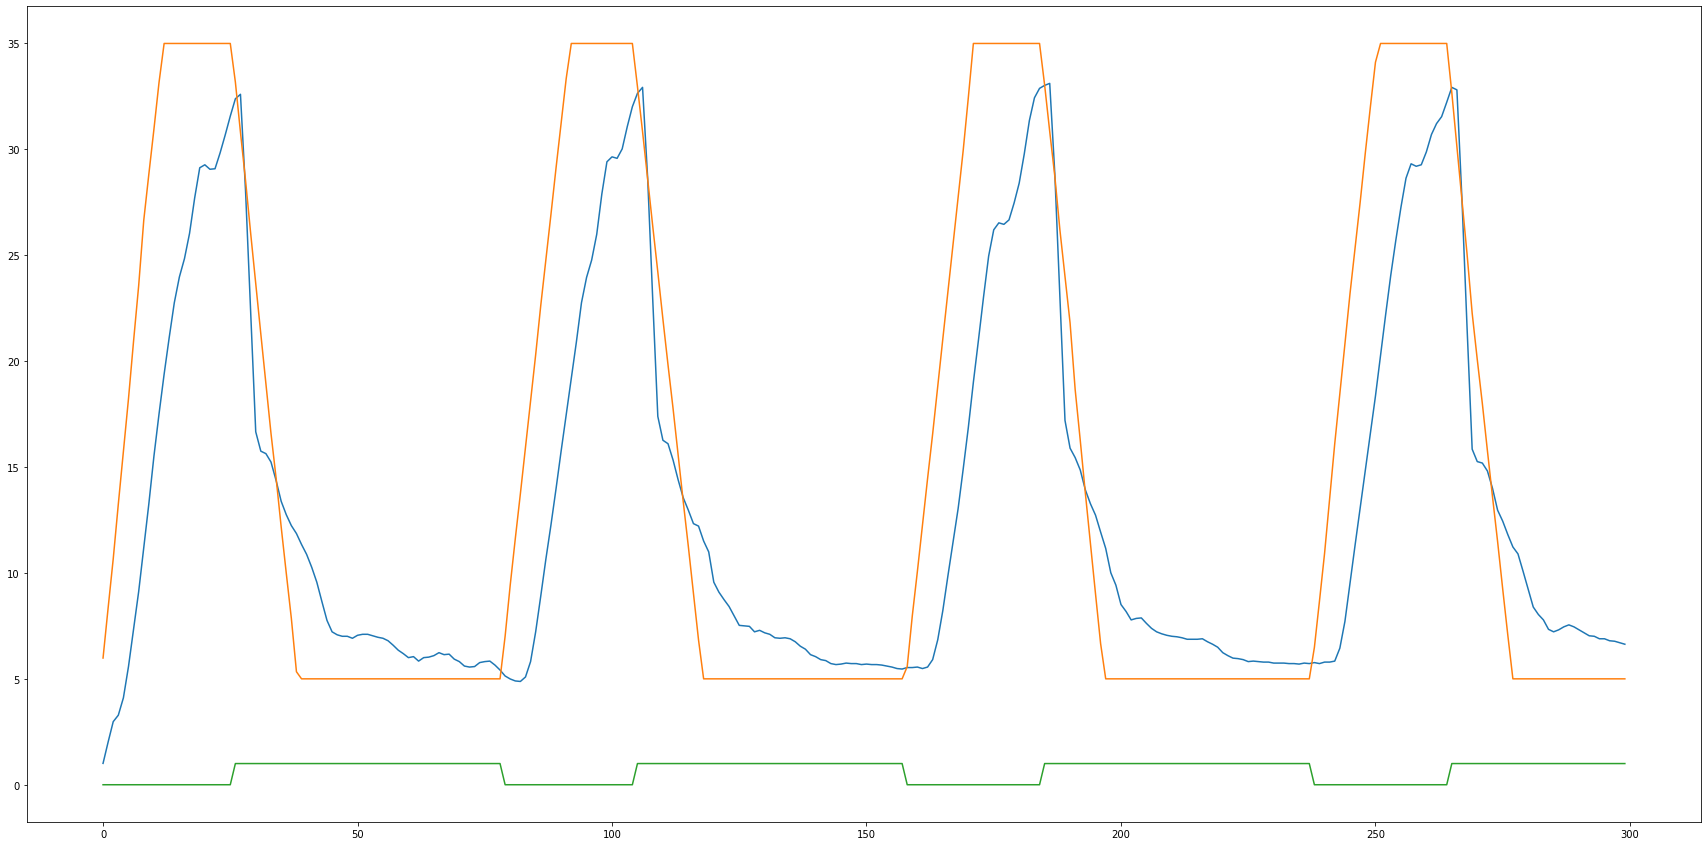

In [18]:
plt.plot(pressures)
plt.plot(pid.waveform.at(timestamps))
plt.plot(u_outs)

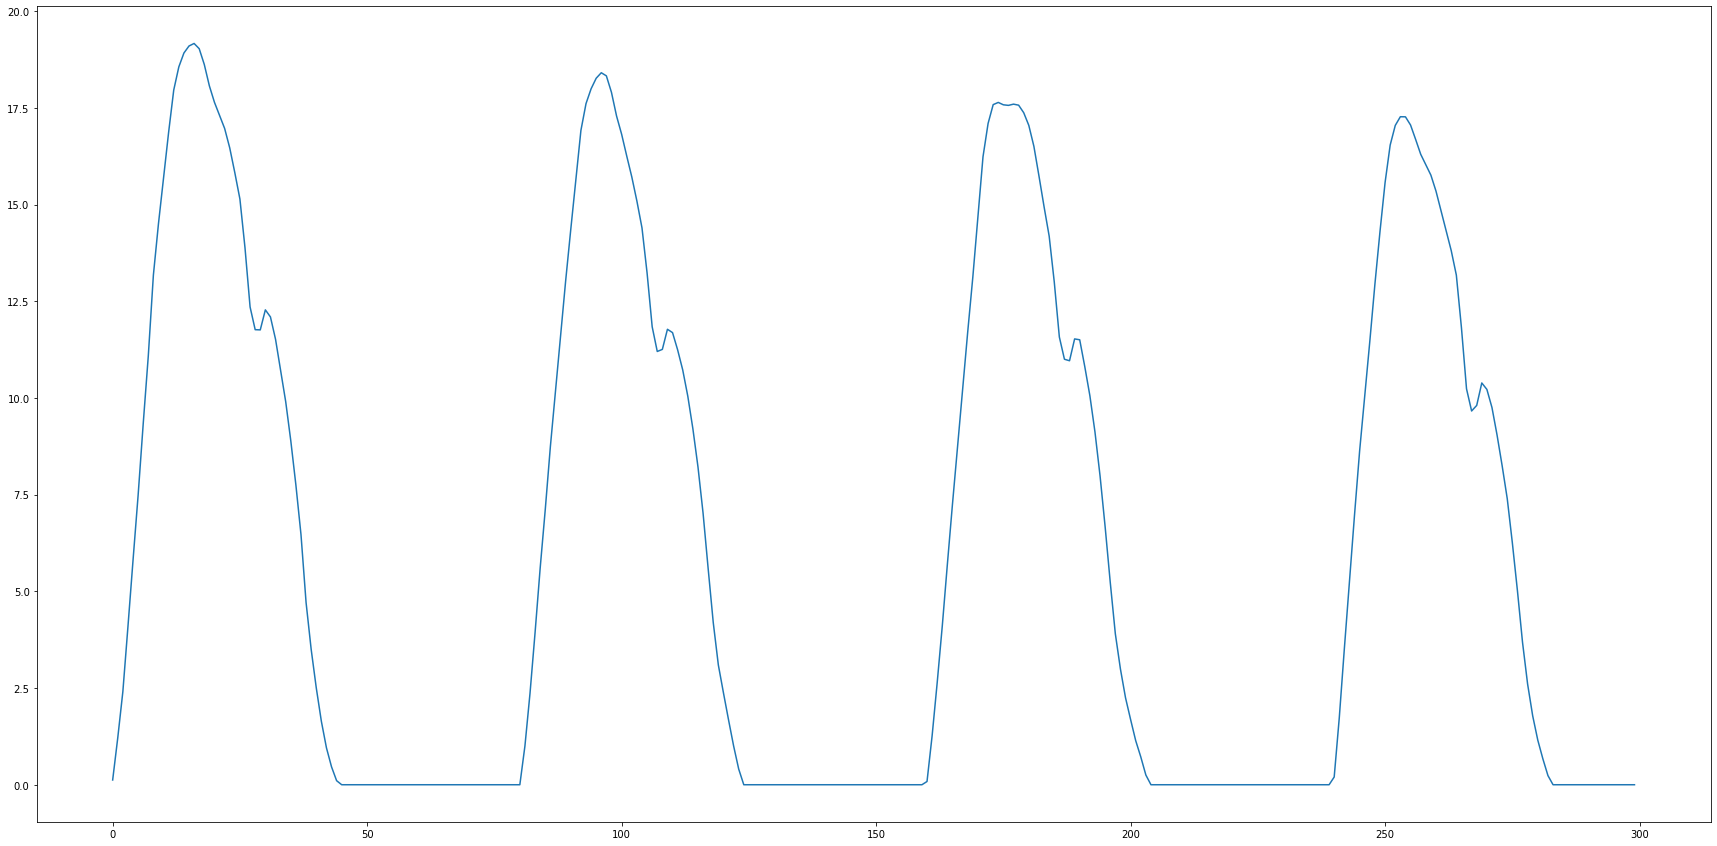

In [19]:
plt.plot(u_ins)

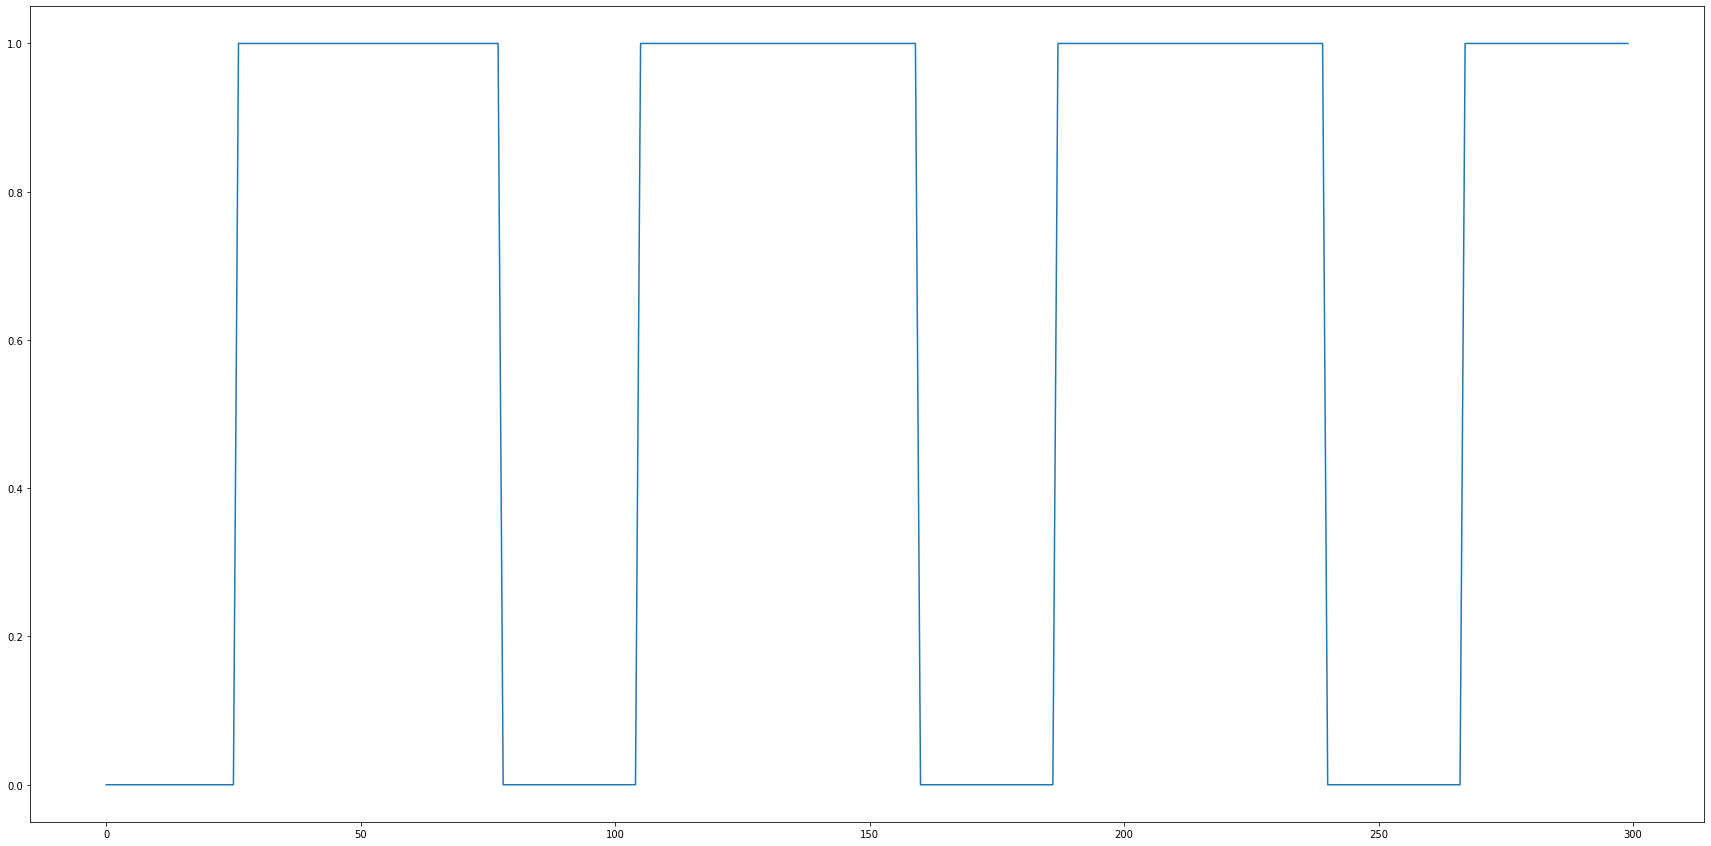

In [101]:
plt.plot(u_outs)

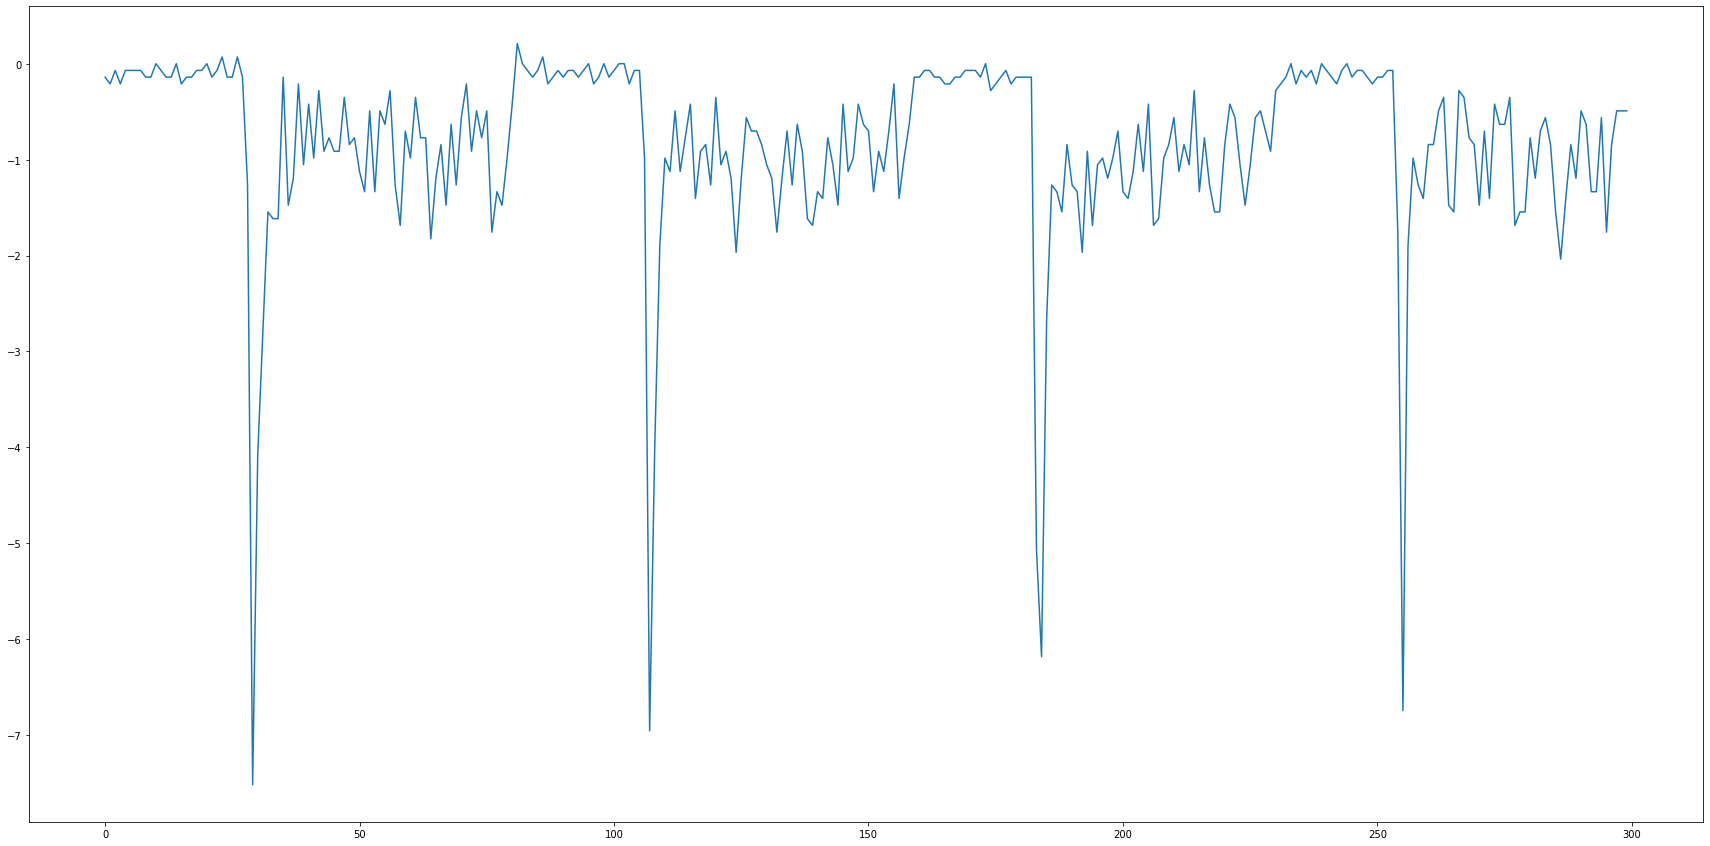

In [193]:
plt.plot(flow_exs)

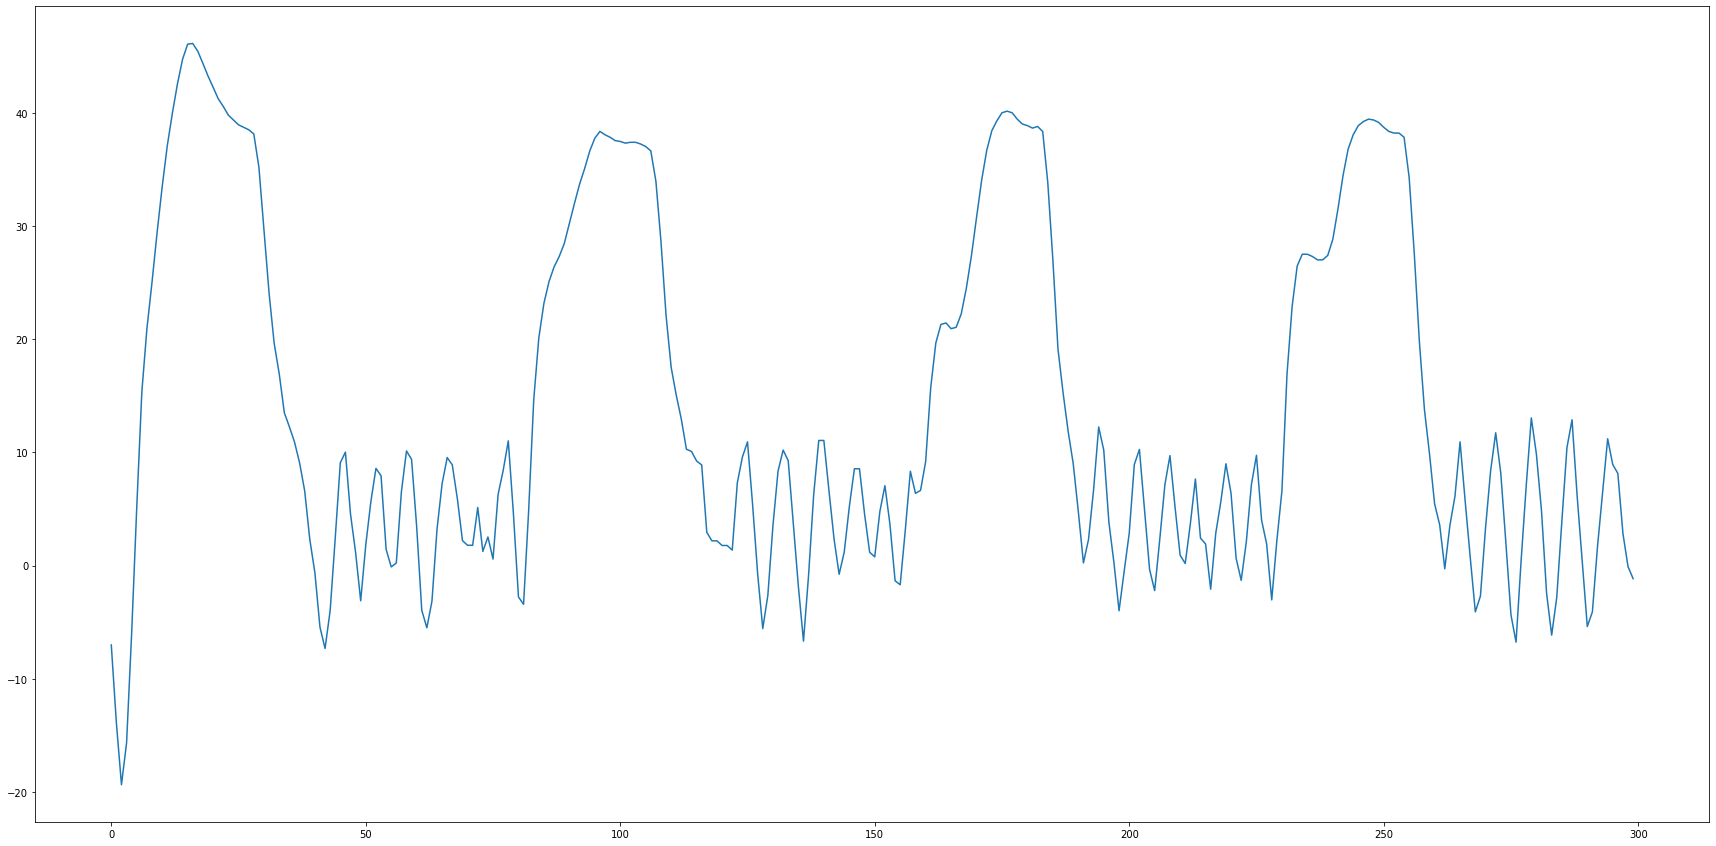

In [194]:
plt.plot(pressures)